In [1]:
import numpy as np
import scipy.constants
from scipy.interpolate import CubicSpline
from scipy.spatial.distance import cdist
import scipy.signal
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib as mpl
from matplotlib import font_manager

font_manager.fontManager.addfont('times.ttf')
plt.rcParams['font.family'] = 'Times New Roman'
# Adjusting font size globally
plt.rcParams.update({'font.size': 15})
# Set the global font to be Times New Roman
mpl.rc('font', family='Times New Roman')
# File name and path
#fname = 'sample'
#path = ''
#datapath = f'{path}{fname}.mat'

# Load data (use scipy.io.loadmat or similar method depending on data format)
#data = scipy.io.loadmat(datapath)
# skel_hist = data['skel_hist']

skel_hist = np.load('sample_3.npy')

ImportError: cannot import name 'int' from 'numpy' (/home/yi/anaconda3/lib/python3.8/site-packages/numpy/__init__.py)

# View Control

In [88]:
# Specify the origin point
origin_x = 0
origin_y = -3
origin_z = 0.5

# Desired new moving direction angle in degrees (e.g., 45 degrees)
delta_angle = 0 # positive right, negative left

# Sample trajectory data
x = skel_hist[0, 0, :]  # x-coordinates
y = skel_hist[0, 2, :]  # y-coordinates

# Translate the trajectory to the new origin
translated_x = x - origin_x
translated_y = y - origin_y

# Combine the translated x and y data
translated_trajectory = np.column_stack((translated_x, translated_y))

# Perform PCA
pca = PCA(n_components=1)
pca.fit(translated_trajectory)

# Extract the principal component
main_direction = pca.components_[0]

# Calculate the angle of the main direction
angle = np.arctan2(main_direction[1], main_direction[0]) * 180 / np.pi
desired_angle =  delta_angle + angle

# Display the main direction angle
print('Angle of the main moving direction (degrees) from the given origin:')
print(angle)

# Calculate the new x-coordinate of the origin to achieve the desired angle
# The new direction vector based on the desired angle
new_direction_x = np.cos(np.radians(desired_angle))
new_direction_y = np.sin(np.radians(desired_angle))

# Adjust the origin's x-coordinate
# Use the relationship tan(angle) = (y2 - y1) / (x2 - x1)
# Here, x2 is the new origin_x we want to find, with y2 = origin_y
# and y1 and x1 being the mean values of the translated trajectory
distance = np.sqrt((x[0]-origin_x)**2 + (y[0]-origin_y)**2)
# keep distance and rotate the  origin to get the desired angle
new_origin_x = x[0] - distance * np.sin(np.radians(angle - desired_angle))
new_origin_y = y[0] - distance * np.cos(np.radians(angle - desired_angle))

# Display the new origin
print('New origin (x, y):')
print((new_origin_x, new_origin_y))

Angle of the main moving direction (degrees) from the given origin:
66.4569282303817
New origin (x, y):
(0.20350149728839032, -3.0063973612006776)


0.0 0.013356179866542278


<Figure size 1300x300 with 0 Axes>

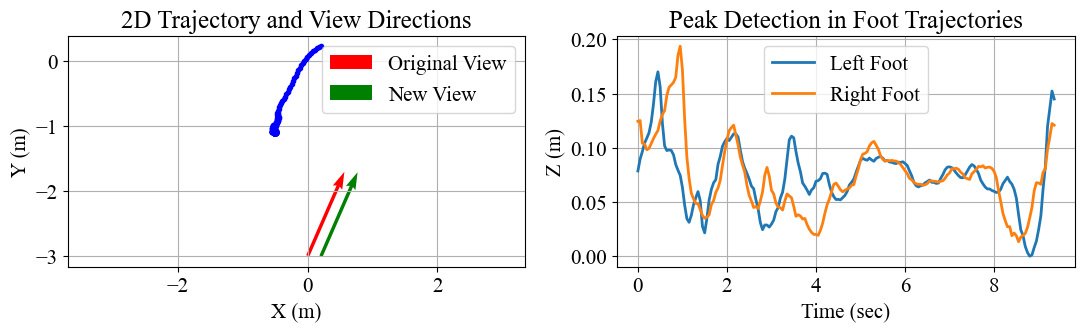

In [89]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

time_resolution = 0.05
time_array = np.arange(0, len(skel_hist[3, 1]) * time_resolution, time_resolution)

# Create a figure with two subplots
plt.figure(figsize=(13, 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))

# First subplot
# plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
ax1.plot(x, y, 'b.-')  # Original trajectory
ax1.quiver(origin_x, origin_y, main_direction[0], main_direction[1], scale=5, color='r', label='Original View')
ax1.quiver(new_origin_x, new_origin_y, new_direction_x, new_direction_y, scale=5, color='g', label='New View')
ax1.axis('equal')
ax1.set_title('2D Trajectory and View Directions')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.grid(True)
ax1.legend()

# Second subplot for peak detection
# plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot


print(min(skel_hist[3, 1]), min(skel_hist[8, 1]))
skel_hist -= min(skel_hist[3, 1])
# Assuming skel_hist is a numpy array or similar structure
peaks_1, _ = find_peaks(skel_hist[3, 1], height =0.05, distance=20)
peaks_2, _ = find_peaks(skel_hist[8, 1], height =0.05, distance=20)

ax2.plot(time_array, skel_hist[3, 1], linewidth=2, label='Left Foot')
ax2.plot(time_array, skel_hist[8, 1], linewidth=2, label='Right Foot')
#ax2.scatter(peaks_1, skel_hist[3, 1][peaks_1], color='red', marker='o')
#ax2.scatter(peaks_2, skel_hist[8, 1][peaks_2], color='red', marker='o')
ax2.set_xlabel('Time (sec)')
ax2.set_ylabel('Z (m)')
ax2.set_title('Peak Detection in Foot Trajectories')
ax2.grid(True)
ax2.legend()

# Show the complete figure with both subplots
plt.savefig('control.png', dpi=300, bbox_inches='tight')

In [90]:
peaks = np.append(peaks_1, skel_hist.shape[2])
print(peaks)
skel_hist.shape
segment[3,:1,:]

[  9  44  69 109 150 186 188]


array([[0.06244911, 0.05864564, 0.05738745, 0.05943009, 0.07362834,
        0.08174943, 0.08550233, 0.08408735, 0.08498368, 0.08736995,
        0.09079224, 0.08968456]])

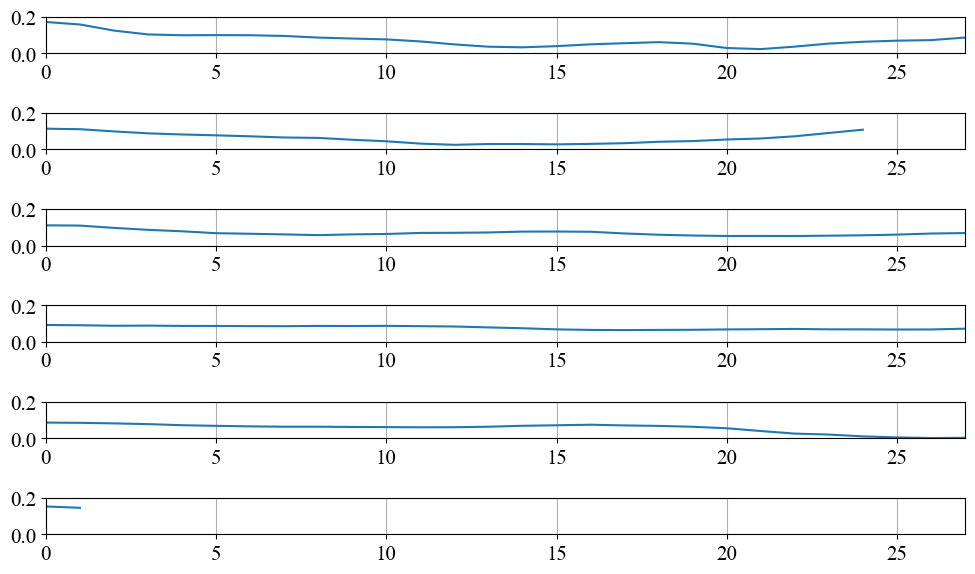

In [91]:
segments = [skel_hist[:,:,peaks[i]:peaks[i+1]] for i in range(len(peaks)-1)]
max_length = max(len(segment) for segment in segments)
fig, axes = plt.subplots(len(segments), 1, figsize=(10, 6))
for ax, segment in zip(axes, segments):
    ax.plot(segment[3,1,:])
    ax.set_xlim([0, max_length])
    ax.set_ylim([0, 0.2])
    ax.grid(True)

plt.tight_layout()
plt.show()

# Radar Parameters

In [92]:
# Radar parameters
c = scipy.constants.speed_of_light  # Speed of light
BW = 4e9  # Bandwidth
start_freq = 77e9
end_freq = start_freq + BW
fc = (start_freq + end_freq) / 2  # Carrier frequency
numADC = 256  # Number of ADC samples
NPpF = 256
frameDuration = 20e-3
T = frameDuration / NPpF  # PRI
PRF = 1 / T
F = numADC / T  # Sampling frequency
dt = 1 / F  # Sampling interval
slope = BW / T
lambda_ = c / fc

t_onePulse = np.arange(0, dt * numADC, dt)
numTX = 1
numRX = 1
Vmax = lambda_ / (T * 4)  # Max Unambiguous velocity m/s
DFmax = 1 / 2 * PRF  # Max Unambiguous Doppler Frequency
dR = c / (2 * BW)  # range resolution
Rmax = F * c / (2 * slope)  # Max range
Rmax2 = c / (2 * PRF)

d_rx = lambda_ / 2  # distance between RXs
d_tx = 4 * d_rx  # distance between TXs

N_range = numADC  # length of range FFT
N_azimuth = numTX * numRX
R = np.arange(0, Rmax, dR)  # range axis
ang_ax = np.arange(-90, 91)  # angle axis

powerTx = 30 # dB

# Antennas
radar_loc_bias = np.array([new_origin_x, origin_z, new_origin_y])
tx_loc = [np.array([(i) * d_tx, 0, 0]) + radar_loc_bias for i in range(numTX)]
rx_loc = [np.array([tx_loc[-1][0] + d_tx + (i) * d_rx, 0, 0]) + radar_loc_bias for i in range(numRX)]
print(tx_loc)

[array([ 0.2035015 ,  0.5       , -3.00639736])]


In [93]:
# Targets
fps_skel = 20
num_tar = skel_hist.shape[0]  # Assuming skel_hist is a numpy array
durationx = skel_hist.shape[2] / fps_skel
numChirps = int(durationx * NPpF * (1 / frameDuration))
tar_loc = np.zeros((num_tar, skel_hist.shape[1], numChirps))
vel_hist = np.zeros((num_tar, skel_hist.shape[1]))

for t in range(num_tar):
    for i in range(skel_hist.shape[1]):
        x = np.linspace(1, skel_hist.shape[2], numChirps)
        cs = CubicSpline(np.arange(1, skel_hist.shape[2] + 1), skel_hist[t, i, :])
        tar_loc[t, i, :] = cs(x)
        vel_hist[t, i] = (np.max(tar_loc[t, i, :]) - np.min(tar_loc[t, i, :])) * np.sqrt(3) / durationx

tt = tar_loc[0, 2, :]
v_avg = np.mean(vel_hist, axis=1)

# TX
delays_targets = np.empty((numTX, numRX, num_tar), dtype=object)

for t in range(num_tar):
    for i in range(numTX):
        for j in range(numRX):
            # Reshape tar_loc to 2D array: (numChirps, 3)
            tar_loc_rep = tar_loc[t, :, :].T
            # Calculate distances
            dist_rx = cdist(tar_loc_rep, rx_loc[j][np.newaxis, :])
            dist_tx = cdist(tar_loc_rep, tx_loc[i][np.newaxis, :])
            delays_targets[i, j, t] = (dist_rx + dist_tx) / c

dd = delays_targets[0, 0, 0]
numChirps = len(dd)

# RCS Calculation

In [94]:
class RadarRCSProcessor:
    def __init__(self, tar_loc, tx_loc, rx_loc, powerTx, numChirps):
        self.tar_loc = tar_loc
        self.tx_loc = tx_loc
        self.rx_loc = rx_loc
        self.powerTx = powerTx
        self.numChirps = numChirps
        self.amp_all = np.zeros([tar_loc.shape[0],numChirps])

    def rcs_ellipsoid(self, a, b, c, phi, theta):
        """
        Calculate the radar cross section (RCS) of an ellipsoid.
        """
        nomi = np.pi * a**2 * b**2 * c**2
        denomi = ((a**2) * (np.sin(theta)**2) * (np.cos(phi)**2) +
                  (b**2) * (np.sin(theta)**2) * (np.sin(phi)**2) +
                  (c**2) * (np.cos(theta)**2))**2
        return nomi / denomi

    def calculate_angles(self, tx_loc, body_part, aspect_vector, r_dist):
        """
        Calculate theta and phi angles for radar processing.
        """
        A = tx_loc - body_part
        A_dot_aspect_vector = np.dot(A, aspect_vector)
        norm_A = np.sqrt(np.sum(A**2))
        norm_aspect_vector = np.sqrt(np.sum(aspect_vector**2))
        theta_angle = np.arccos(A_dot_aspect_vector / (norm_A * norm_aspect_vector))
        phi_angle = np.arcsin((tx_loc[1] - body_part[1]) / np.sqrt(r_dist[0]**2 + r_dist[1]**2))
        return theta_angle, phi_angle

    def process_body_part(self, target_id, end_part_index, ellipsoid_params):
        """
        Process radar returns for a specific body part.
        """
        body_part = np.zeros([3, self.numChirps])
        ref_point = np.zeros([3, self.numChirps])
        #amp = np.zeros([len(target_id), self.numChirps])

        for k in range(self.numChirps):
            body_part[:, k] = self.tar_loc[end_part_index[0], :, k]
            ref_point[:, k] = self.tar_loc[end_part_index[1], :, k]
            body_part_length = np.sqrt(np.sum((body_part[:, k] - ref_point[:, k]) ** 2))

            r_dist = np.abs(body_part[:, k] - self.tx_loc[0].T)
            dist_tx = np.sqrt(np.sum(r_dist ** 2, axis=0))

            aspect_vector = body_part[:, k] - ref_point[:, k]
            theta_angle, phi_angle = self.calculate_angles(self.tx_loc[0], body_part[:, k], aspect_vector, r_dist)
            a, b = ellipsoid_params
            c = body_part_length / 2 # Update c based on the body part length
            rcs = self.rcs_ellipsoid(a, b, c, phi_angle, theta_angle)
            dist_rx = np.sqrt(np.sum((body_part[:, k] - self.rx_loc[0].T) ** 2))
            self.amp_all[target_id, k] = np.sqrt(rcs * self.powerTx) / (dist_tx * dist_rx)


rcs_processor = RadarRCSProcessor(tar_loc, tx_loc, rx_loc, powerTx, numChirps)
# head
rcs_processor.process_body_part(target_id=[14, 15], end_part_index=[14, 15], ellipsoid_params=(0.1, 0.1))
# hip
rcs_processor.process_body_part(target_id=[0], end_part_index=[0, 11], ellipsoid_params=(0.1, 0.1))
# torso
rcs_processor.process_body_part(target_id=[11, 12, 13,], end_part_index=[11, 14], ellipsoid_params=(0.15, 0.15))
# left shoulder
rcs_processor.process_body_part(target_id=[17], end_part_index=[14, 17], ellipsoid_params=(0.06, 0.06))
# right shoulder
rcs_processor.process_body_part(target_id=[22], end_part_index=[14, 22], ellipsoid_params=(0.06, 0.06))
# left upper arm
rcs_processor.process_body_part(target_id=[18], end_part_index=[17, 18], ellipsoid_params=(0.06, 0.06))
# right upper arm
rcs_processor.process_body_part(target_id=[23], end_part_index=[22, 23], ellipsoid_params=(0.06, 0.06))
# left lower arm
rcs_processor.process_body_part(target_id=[19], end_part_index=[18, 19], ellipsoid_params=(0.05, 0.05))
# right lower arm
rcs_processor.process_body_part(target_id=[24], end_part_index=[23, 24], ellipsoid_params=(0.05, 0.05))
# left hand
rcs_processor.process_body_part(target_id=[20], end_part_index=[19, 20], ellipsoid_params=(0.06, 0.02))
# right hand
rcs_processor.process_body_part(target_id=[25], end_part_index=[24, 25], ellipsoid_params=(0.06, 0.02))
# left upper leg
rcs_processor.process_body_part(target_id=[1], end_part_index=[0, 1], ellipsoid_params=(0.07, 0.07))
# right upper leg
rcs_processor.process_body_part(target_id=[6], end_part_index=[0, 6], ellipsoid_params=(0.07, 0.07))
# left lower leg
rcs_processor.process_body_part(target_id=[2], end_part_index=[1, 2], ellipsoid_params=(0.06, 0.06))
# right lower leg
rcs_processor.process_body_part(target_id=[7], end_part_index=[6, 7], ellipsoid_params=(0.06, 0.06))
# left foot
rcs_processor.process_body_part(target_id=[3], end_part_index=[3, 4], ellipsoid_params=(0.05, 0.05))
# right foot
rcs_processor.process_body_part(target_id=[8], end_part_index=[8, 9], ellipsoid_params=(0.05, 0.05))

In [95]:
amp = rcs_processor.amp_all
print(amp[:,0])

[0.05107689 0.05586264 0.10236783 0.03985789 0.         0.
 0.05149176 0.04833537 0.03462318 0.         0.         0.11465981
 0.11465981 0.11465981 0.15338092 0.15338092 0.         0.04435021
 0.03742595 0.0437977  0.05746756 0.         0.04443715 0.04007333
 0.03214735 0.12426204 0.        ]


# Signal Generation Considering With RCS

In [ ]:
# Define phase functions
phase = lambda tx, fx: 2 * np.pi * (fx * tx + slope / 2 * tx**2)
phase2 = lambda tx, fx, r, v: 2 * np.pi * (2 * fx * r / c + tx * (2 * fx * v / c + 2 * slope * r / c))

phase_t = phase(t_onePulse, fc)

# Initialize the mixed signal array
mixed = np.zeros((numTX, numRX, numChirps * numADC), dtype=complex)

for i in range(numTX):
    for j in range(numRX):
        print(f'Processing Channel: {j+1}/{numRX}')
        for t in range(num_tar):
            print(f'{t+1}/{num_tar}')
            signal_tar = np.zeros(numChirps * numADC, dtype=complex)
            for k in range(numChirps):
                phase_tar = phase(t_onePulse - delays_targets[i, j, t][k], fc)  # received
                signal_tar[k*numADC:(k+1)*numADC] = np.exp(1j * (phase_t - phase_tar))
            mixed[i, j, :] += np.repeat(amp[t, :], numADC) * signal_tar.conj()

Processing Channel: 1/1
1/27
2/27
3/27
4/27
5/27
6/27
7/27
8/27
9/27
10/27
11/27
12/27
13/27


# Signal Generation Considering Without RCS

In [ ]:
# Define phase functions
phase = lambda tx, fx: 2 * np.pi * (fx * tx + slope / 2 * tx**2)
phase2 = lambda tx, fx, r, v: 2 * np.pi * (2 * fx * r / c + tx * (2 * fx * v / c + 2 * slope * r / c))

phase_t = phase(t_onePulse, fc)

# Initialize the mixed signal array
mixed = np.zeros((numTX, numRX, numChirps * numADC), dtype=complex)

for i in range(numTX):
    for j in range(numRX):
        print(f'Processing Channel: {j+1}/{numRX}')
        for t in range(num_tar):
            print(f'{t+1}/{num_tar}')
            signal_tar = np.zeros(numChirps * numADC, dtype=complex)
            for k in range(numChirps):
                phase_tar = phase(t_onePulse - delays_targets[i, j, t][k], fc)  # received
                signal_tar[k*numADC:(k+1)*numADC] = np.exp(1j * (phase_t - phase_tar))
            mixed[i, j, :] += signal_tar

Processing Channel: 1/1
1/27
2/27
3/27
4/27
5/27
6/27
7/27
8/27
9/27
10/27
11/27
12/27
13/27
14/27
15/27
16/27
17/27
18/27
19/27
20/27
21/27
22/27
23/27
24/27
25/27
26/27
27/27


# Signal Processing

In [ ]:
def myspecgramnew(data, window, nfft, shift):
    N = int((len(data) - window - 1) / shift)
    out1 = np.zeros((nfft, N), dtype=complex)  # Initialize the output array

    for i in range(N):
        start_index = i * shift
        end_index = start_index + window
        segment = data[start_index:end_index]
        windowed_segment = segment * np.hanning(window)  # Apply Hann window
        fft_result = np.fft.fft(windowed_segment, nfft)  # FFT
        out1[:, i] = fft_result

    return out1

# Assuming 'mixed' is the complex signal data and 'myspecgramnew' is already defined

# Reshape and permute RDC
RDC = mixed.reshape(numTX*numRX, numADC, numChirps, order="F")
RDC = np.transpose(RDC, (1, 2, 0))

numCPI = numChirps // NPpF
RDMs = np.zeros((numADC, NPpF, numTX*numRX, numCPI))

rBin = np.arange(256)
nfft = 256
window = 256
noverlap = 200
shift = window - noverlap



# Summing along the antenna dimension and applying the FFT
range_profile = np.fft.fft(RDC[rBin, :, 0], axis=0)
# Subtract the mean from the range profile
# mean_profile = np.mean(range_profile, axis=1, keepdims=True)
# range_profile = range_profile - mean_profile
# mti_filtered = np.diff(range_profile, axis=1)

from scipy.signal import butter, lfilter
# Butterworth filter parameters
order = 4       # Filter order
cutoff = 0.0075 # Cutoff frequency as a fraction of the Nyquist rate
# Design Butterworth high-pass filter
b, a = butter(order, cutoff, 'high')
#mti_filtered = lfilter(b, a, range_profile, axis=1)
# Apply the filter to each row
ns = range_profile.shape[1]
mti_filtered = np.zeros_like(range_profile)
for k in range(range_profile.shape[0]):
    mti_filtered[k, :ns] = lfilter(b, a, range_profile[k, :ns])

# Remove the first row from the filtered data
mti_filtered = mti_filtered[1:, :]

# To keep the original shape, you can pad the result
# For example, pad with zeros at the beginning or end
# mti_filtered_padded = np.pad(mti_filtered, ((0, 0), (1, 0)), mode='constant')
RDC_summed = np.sum(mti_filtered, axis=0)

# Generate the spectrogram
sx = myspecgramnew(RDC_summed, window, nfft, shift)

# Post-processing for visualization
sx2 = np.abs(np.fft.fftshift(np.flipud(sx), axes=0))

# Visualization

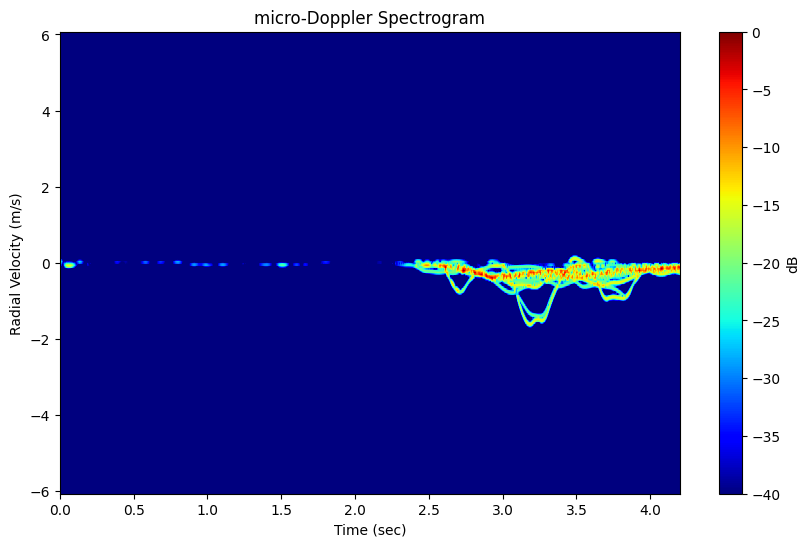

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'sx2' is the spectrogram data from the previous steps

# Time and Frequency Axes
timeAxis = np.linspace(0, numCPI * frameDuration, numCPI)
freqAxis = np.linspace(-Vmax / 2, Vmax / 2, nfft)

# Visualization
plt.figure(figsize=(10, 6))
plt.imshow(20 * np.log10(np.abs(sx2 / np.max(sx2))), extent=[timeAxis[0], timeAxis[-1], freqAxis[0], freqAxis[-1]], aspect='auto', origin='lower')
plt.title('micro-Doppler Spectrogram')
plt.xlabel('Time (sec)')
plt.ylabel('Radial Velocity (m/s)')
plt.colorbar(label='dB')
plt.clim(20 * np.log10(np.abs(sx2 / np.max(sx2))).max() - 40, 20 * np.log10(np.abs(sx2 / np.max(sx2))).max())
plt.set_cmap('jet')
#plt.axis([0, 8, -2, 2])
plt.show()

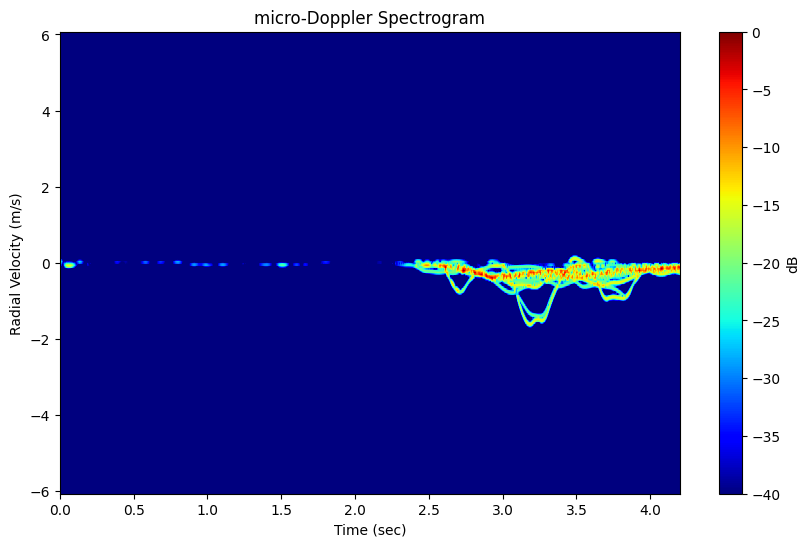

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'sx2' is the spectrogram data from the previous steps

# Time and Frequency Axes
timeAxis = np.linspace(0, numCPI * frameDuration, numCPI)
freqAxis = np.linspace(-Vmax / 2, Vmax / 2, nfft)

# Visualization
plt.figure(figsize=(10, 6))
plt.imshow(20 * np.log10(np.abs(sx2 / np.max(sx2))), extent=[timeAxis[0], timeAxis[-1], freqAxis[0], freqAxis[-1]], aspect='auto', origin='lower')
plt.title('micro-Doppler Spectrogram')
plt.xlabel('Time (sec)')
plt.ylabel('Radial Velocity (m/s)')
plt.colorbar(label='dB')
plt.clim(20 * np.log10(np.abs(sx2 / np.max(sx2))).max() - 40, 20 * np.log10(np.abs(sx2 / np.max(sx2))).max())
plt.set_cmap('jet')
#plt.axis([0, 8, -2, 2])
plt.show()

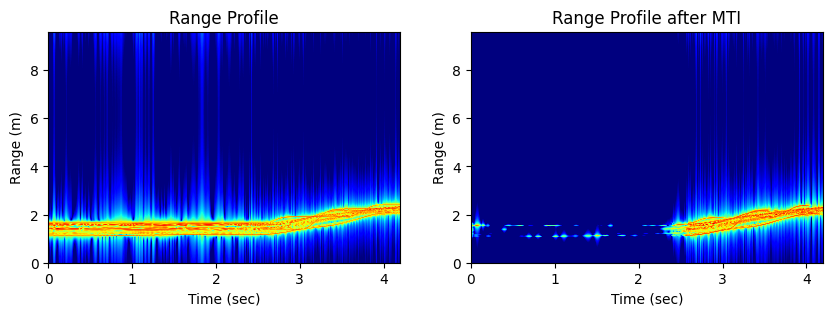

In [ ]:
# prompt: plt figure, two subplots in  a row, one plot range profile, the other plot mti_filtered
# Time and Frequency Axes
timeAxis = np.linspace(0, numCPI * frameDuration, numCPI)
rangeAxis = np.linspace(0, Rmax, nfft)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cax_0 = axs[0].imshow(20 * np.log10(np.abs(range_profile / np.max(range_profile))), extent=[timeAxis[0], timeAxis[-1], rangeAxis[0], rangeAxis[-1]], aspect='auto', origin='lower')
cax_0.set_clim(20 * np.log10(np.abs(range_profile / np.max(range_profile))).max() - 50, 20 * np.log10(np.abs(range_profile / np.max(range_profile))).max())
axs[0].set_title('Range Profile')
axs[0].set_xlabel('Time (sec)')
axs[0].set_ylabel('Range (m)')
cax_1 = axs[1].imshow(20 * np.log10(np.abs(mti_filtered / np.max(mti_filtered))), extent=[timeAxis[0], timeAxis[-1], rangeAxis[0], rangeAxis[-1]], aspect='auto', origin='lower')
cax_1.set_clim(20 * np.log10(np.abs(mti_filtered / np.max(mti_filtered))).max() - 50, 20 * np.log10(np.abs(mti_filtered / np.max(mti_filtered))).max())
axs[1].set_title('Range Profile after MTI')
axs[1].set_xlabel('Time (sec)')
axs[1].set_ylabel('Range (m)')
plt.set_cmap('jet')
plt.show()